# Red Neuronal

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,targetBooleano,regularizar,reemplazarCategoricas_HashTrick,reemplazarNullsNum, normalizar_HashTrick

[###] Initial Preprocessings Done                           
[###] Aditional Preprocessings Done                                                   


### Codigo a correr

In [4]:
MAX_ITER = 10**4
MAX_JOBS = -1

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [5]:
runSimple = True
runMlpC = True
runMlpC_R = True
runHt = True
runHtN = True

**Save :** Guardar Modelo (pisa anterior)

In [6]:
saveMlpC = True
saveMlpC_R = True
saveHt = True
saveHtN = True
saveBest = True

In [7]:
predictions = pd.DataFrame()

In [8]:
from utilities import score, score2, df_feat, df_targ, train_val

### Preprocesamiento

In [9]:
targetBooleano(df_targ, inplace=True)
ht_feat = reemplazarCategoricas_HashTrick(df_feat)

reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)

df_feat_r = regularizar(df_feat)

reemplazarFechas(ht_feat , inplace=True)
reemplazarNullsNum(ht_feat, inplace=True)
ht_feat2 = normalizar_HashTrick(ht_feat)

In [10]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ, True )
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ, True )
train_feat_ht, val_feat_ht, train_targ_ht, val_targ_ht = train_val( ht_feat, df_targ, True )
train_feat_ht2, val_feat_ht2, train_targ_ht2, val_targ_ht2 = train_val( ht_feat2, df_targ, True )

In [11]:
layer_sizes = []
for i in range(6,13,3):
    for j in range(6,13,3):
        layer_sizes.append( ( i+1, j+1 ) )
layer_sizes.append( ( 20, 20 ) )

In [12]:
params = {
    'alpha': np.arange(1e-5,10e-5,1e-5),
    'hidden_layer_sizes':layer_sizes,
    'activation': ['logistic', 'relu'],
}

## Simple

In [13]:
if (runSimple):
    mlp = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    ).fit(train_feat, train_targ)

AUC-ROC: 0.8499260840366799
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      7946
        True       0.74      0.42      0.53      2290

    accuracy                           0.84     10236
   macro avg       0.79      0.69      0.72     10236
weighted avg       0.83      0.84      0.82     10236

CONFUSION MATRIX


None

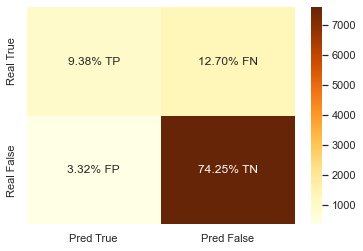

In [14]:
if (runSimple):
    pred = mlp.predict(val_feat)
    prob = mlp.predict_proba(val_feat)
    display(score(val_targ, pred, prob[:,1]))
    pdf = score2('Simple','Basico',val_targ, pred, prob[:,1])
    predictions = predictions.append( pdf )

## MLP Clasifier

In [15]:
if (runMlpC):
    mlp_cls = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    
    mlp_cls_grid = HalvingGridSearchCV(
        mlp_cls,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveMlpC):
        dump(mlp_cls_grid, 'models/NN/mlp_cls_grid.sk')
else:
    # Cargar
    mlp_cls_grid = load('models/NN/mlp_cls_grid.sk')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1137
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 1137
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 60
n_resources: 3411
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 20
n_resources: 10233
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 30699
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 92097
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [16]:
print(f"Best score: {mlp_cls_grid.best_score_}")
print(f"Best params {mlp_cls_grid.best_params_}")

Best score: 0.8563582581467761
Best params {'activation': 'relu', 'alpha': 6e-05, 'hidden_layer_sizes': (13, 7)}


In [17]:
mlp_cls = mlp_cls_grid.best_estimator_

AUC-ROC: 0.8511153341825882
              precision    recall  f1-score   support

       False       0.83      0.98      0.90      7946
        True       0.79      0.30      0.44      2290

    accuracy                           0.83     10236
   macro avg       0.81      0.64      0.67     10236
weighted avg       0.82      0.83      0.79     10236

CONFUSION MATRIX
CPU times: user 469 ms, sys: 93.1 ms, total: 562 ms
Wall time: 186 ms


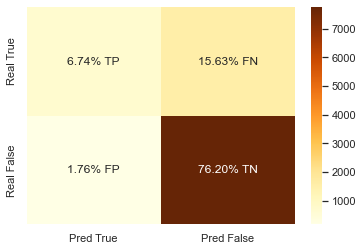

In [18]:
%%time
pred = mlp_cls.predict(val_feat)
prob = mlp_cls.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [19]:
pdf = score2('Val','Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

## MLP Clasifier - Features Regularizados

In [20]:
if (runMlpC_R):
    mlp_cls_r = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    
    mlp_cls_r_grid = HalvingGridSearchCV(
        mlp_cls_r,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveMlpC_R):
        dump(mlp_cls_r_grid, 'models/NN/mlp_cls_r_grid.sk')
        dump(mlp_cls_r_grid.best_estimator_, 'models/NN/mlp_cls_r.sk')
else:
    # Cargar
    mlp_cls_r_grid = load('models/NN/mlp_cls_r_grid.sk')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1137
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 1137
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 60
n_resources: 3411
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 20
n_resources: 10233
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 30699
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 92097
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [21]:
print(f"Best score: {mlp_cls_r_grid.best_score_}")
print(f"Best params {mlp_cls_r_grid.best_params_}")

Best score: 0.869241261450471
Best params {'activation': 'logistic', 'alpha': 9e-05, 'hidden_layer_sizes': (13, 13)}


In [22]:
mlp_cls_r = mlp_cls_r_grid.best_estimator_

AUC-ROC: 0.8648563392418476
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      7946
        True       0.71      0.49      0.58      2290

    accuracy                           0.84     10236
   macro avg       0.79      0.71      0.74     10236
weighted avg       0.83      0.84      0.83     10236

CONFUSION MATRIX
CPU times: user 309 ms, sys: 90.4 ms, total: 400 ms
Wall time: 166 ms


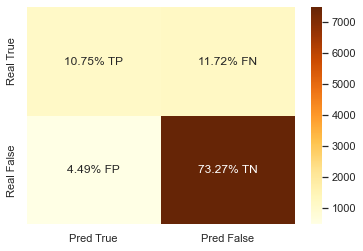

In [23]:
%%time
pred = mlp_cls_r.predict(val_feat_r)
prob = mlp_cls_r.predict_proba(val_feat_r)
score(val_targ_r, pred, prob[:,1])

In [24]:
pdf = score2('Reg','Regularizado',val_targ_r, pred, prob[:,1])
predictions = predictions.append( pdf )

## Hashing Trick

In [25]:
if (runHt):
    mlp_ht = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    
    mlp_ht_grid = HalvingGridSearchCV(
        mlp_ht,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat_ht, train_targ_ht)
    
    # Guardar
    if(saveHt):
        dump(mlp_ht_grid, 'models/NN/mlp_ht_grid.sk')
else:
    # Cargar
    mlp_ht_grid = load('models/NN/mlp_ht_grid.sk')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1137
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 1137
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 60
n_resources: 3411
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 20
n_resources: 10233
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 30699
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 92097
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [26]:
print(f"Best score: {mlp_ht_grid.best_score_}")
print(f"Best params {mlp_ht_grid.best_params_}")

Best score: 0.8604616992766051
Best params {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10, 7)}


In [27]:
mlp_ht = mlp_ht_grid.best_estimator_

AUC-ROC: 0.8619530630885113
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      7946
        True       0.75      0.40      0.52      2290

    accuracy                           0.84     10236
   macro avg       0.80      0.68      0.71     10236
weighted avg       0.82      0.84      0.82     10236

CONFUSION MATRIX
CPU times: user 514 ms, sys: 118 ms, total: 632 ms
Wall time: 220 ms


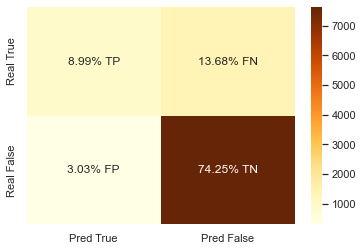

In [28]:
%%time
pred = mlp_ht.predict(val_feat_ht)
prob = mlp_ht.predict_proba(val_feat_ht)
score(val_targ_ht, pred, prob[:,1])

In [29]:
pdf = score2('HT','Hashing Trick',val_targ_ht, pred, prob[:,1])
predictions = predictions.append( pdf )

### Normalizado

In [30]:
if (runHtN):
    mlp_ht2 = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    
    mlp_ht_grid2 = HalvingGridSearchCV(
        mlp_ht2,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat_ht2, train_targ_ht2)
    
    # Guardar
    if(saveHtN):
        dump(mlp_ht_grid2, 'models/NN/mlp_htn_grid.sk')
else:
    # Cargar
    mlp_ht_grid2 = load('models/NN/mlp_htn_grid2.sk')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1137
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 1137
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 60
n_resources: 3411
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 20
n_resources: 10233
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 30699
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 92097
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [31]:
print(f"Best score: {mlp_ht_grid2.best_score_}")
print(f"Best params {mlp_ht_grid2.best_params_}")

Best score: 0.8799514021981425
Best params {'activation': 'logistic', 'alpha': 3.0000000000000004e-05, 'hidden_layer_sizes': (7, 13)}


In [32]:
mlp_htn = mlp_ht_grid2.best_estimator_

AUC-ROC: 0.8791196471378311
              precision    recall  f1-score   support

       False       0.87      0.95      0.91      7946
        True       0.74      0.50      0.60      2290

    accuracy                           0.85     10236
   macro avg       0.81      0.72      0.75     10236
weighted avg       0.84      0.85      0.84     10236

CONFUSION MATRIX
CPU times: user 358 ms, sys: 87.4 ms, total: 445 ms
Wall time: 161 ms


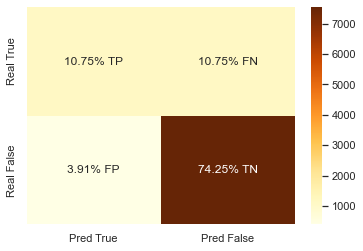

In [33]:
%%time
pred = mlp_htn.predict(val_feat_ht2)
prob = mlp_htn.predict_proba(val_feat_ht2)
score(val_targ_ht2, pred, prob[:,1])

In [34]:
pdf = score2('HTN','Hashing Trick + Normalizado',val_targ_ht2, pred, prob[:,1])
predictions = predictions.append( pdf )

## Resultados

In [35]:
predictions

,Modelo,Preprocesamientos,Clase,AUC-ROC,Accuracy,Precision,Recall,F1 score,Support
0,Simple,Basico,AVG,0.849926,0.836655,0.825691,0.836655,0.818922,10236
1,Simple,Basico,True,NaN,NaN,0.737692,0.418777,0.534262,2290
2,Simple,Basico,False,NaN,NaN,0.851052,0.957085,0.900960,7946
0,Val,Basico,AVG,0.851115,0.826104,0.821101,0.826104,0.794164,10236
1,Val,Basico,True,NaN,NaN,0.793103,0.301310,0.436709,2290
2,Val,Basico,False,NaN,NaN,0.829169,0.977347,0.897181,7946
0,Reg,Regularizado,AVG,0.864856,0.840563,0.829690,0.840563,0.829228,10236
1,Reg,Regularizado,True,NaN,NaN,0.709022,0.487336,0.577640,2290
2,Reg,Regularizado,False,NaN,NaN,0.864465,0.942361,0.901734,7946
0,HT,Hashing Trick,AVG,0.861953,0.835385,0.824932,0.835385,0.815616,10236


In [37]:
if(saveBest):
    dump(mlp_htn, 'models/NN/mlp.sk')